## Load libraries & data

In [1]:
import pandas as pd
import numpy as np
import datetime
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet, Ridge, Lasso, LinearRegression
from sklearn.ensemble import IsolationForest
from sklearn.svm import SVR
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV
import tensorflow as tf


data = pd.read_csv('../assignment-1/data/train.csv')

c:\Users\herre\anaconda3\envs\AdvancedAnalytics_1\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\herre\anaconda3\envs\AdvancedAnalytics_1\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\herre\anaconda3\envs\AdvancedAnalytics_1\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


## Data preprocessing

In [2]:
# Create groups for categorical variables
property_type_groups = [['Apartment','Serviced apartment'], ['House','Townhouse','Chalet'],['Condominium'],['Guesthouse','Guest suite'],['Loft'],['Bed & Breakfast'],['Other','Boutique hotel','Hostel','Camper/RV','Castle','Boat','Timeshare'],['Villa'],['Cabine','Earth House','Yurt','Dorm','Tent']]
property_room_type_groups = [['Private room'],['Entire home/apt'],['Shared room']]
booking_cancel_policy_groups = [['flexible'],['moderate'],['strict', 'super_strict_30']]
property_bed_type_groups = [['Couch','Airbed','Futon','Pull-out Sofa'],['Real Bed']]
host_response_time_groups = [['a few days or more'],['within a day'],['within a few hours'],['within an hour'],['']]

# Split multilabel columns into separate groups
amenity_groups = [[amenity] for amenity in data['property_amenities'].dropna().str.split(', ').explode().unique().tolist()]  
host_verified_groups = [[verification] for verification in data['host_verified'].dropna().str.split(', ').explode().unique().tolist()]  
extra_groups = [[extra] for extra in data['extra'].dropna().str.split(', ').explode().unique().tolist()]  

# Define preprocessing pipeline
def preprocessing(data):

    df = data.copy()

    # Replace NaN values with empty string
    df[['host_response_time','property_amenities','host_verified','extra']] = df[['host_response_time','property_amenities','host_verified','extra']].fillna('')

    # Count number of amenities
    df['amenities_count'] = df['property_amenities'].apply(lambda x: 0 if pd.isna(x) else x.count(',') + 1)

    # Assign each property to a city (Brussels vs Antwerp)
    df['property_city'] = df['property_lat'].apply(lambda x: 1 if x > 51 else 0)

    # OneHotEncoding of categorical variables
    for group in property_type_groups:
        group_name = 'property_type' + '_' + group[0]
        df[group_name] = df['property_type'].isin(group).astype(int)
    for group in property_room_type_groups:
        group_name = 'property_room_type' + '_' + group[0]
        df[group_name] = df['property_room_type'].isin(group).astype(int)
    for group in booking_cancel_policy_groups:
        group_name = 'booking_cancel_policy' + '_' + group[0]
        df[group_name] = df['booking_cancel_policy'].isin(group).astype(int)
    for group in property_bed_type_groups:
        group_name = 'property_bed_type' + '_' + group[0]
        df[group_name] = df['property_bed_type'].isin(group).astype(int)
    for group in host_response_time_groups:
        group_name = 'host_response_time' + '_' + group[0]
        df[group_name] = df['host_response_time'].isin(group).astype(int)

    # MultiLabelEncoding
    for group in amenity_groups:
        new_col = df['property_amenities'].apply(lambda x: 1 if len(set(x.split(', ')).intersection(group)) > 0 else 0)
        group_name = 'property_amenities' + '_' + group[0]
        df = pd.concat([df, new_col.rename(group_name)], axis=1)
    for group in host_verified_groups:
        new_col = df['host_verified'].apply(lambda x: 1 if len(set(x.split(', ')).intersection(group)) > 0 else 0)
        group_name = 'host_verified' + '_' + group[0]
        df = pd.concat([df, new_col.rename(group_name)], axis=1)
    for group in extra_groups:
        new_col = df['extra'].apply(lambda x: 1 if len(set(x.split(', ')).intersection(group)) > 0 else 0)
        group_name = 'extra' + '_' + group[0]
        df = pd.concat([df, new_col.rename(group_name)], axis=1)

    # Convert property_last_updated to number of days
    def convert_to_days(value, property_scraped_at, host_since):
        if value == 'today':
            return 0
        elif value == 'yesterday':
            return 1
        elif value == 'never':
            property_scraped_at = datetime.datetime.strptime(property_scraped_at, '%Y-%m-%d')
            host_since = datetime.datetime.strptime(host_since, '%Y-%m-%d')
            difference = property_scraped_at - host_since
            return difference.days
        else:
            if value.endswith('day ago'):
                return 1
            elif value.endswith('week ago'):
                return 7
            elif value.endswith('month ago'):
                return 30
            else:
                number, unit, _ = value.split()
                number = int(number)
                if unit == 'days':
                    return number
                elif unit == 'weeks':
                    return number * 7
                elif unit == 'months':
                    return number * 30
                elif unit == 'week':
                    return 7
                elif unit == 'month':
                    return 30
                
    df['property_last_updated'] = df.apply(lambda x: convert_to_days(x['property_last_updated'], x['property_scraped_at'], x['host_since']) if pd.notnull(x['property_last_updated']) else x['property_last_updated'], axis=1)

    return df

## Modeling

In [3]:
# To prevent data leakage, we define our own fold divider for cross-validation
# Prices of rooms at the same property location may be correlated, 
# therefore we avoid having rooms from the same property in both the training and validation set
def k_fold_split(data, k):
    host_ids = data['host_id'].unique()
    np.random.shuffle(host_ids)
    host_id_folds = np.array_split(host_ids, k)
    data['fold'] = 0
    for i in range(k):
        data.loc[data['host_id'].isin(host_id_folds[i]), 'fold'] = i
    return data

In [15]:
# Settings

k = 10
data = k_fold_split(data, k)
data_preprocessed = preprocessing(data)
data_preprocessed.drop(['property_id', 'host_id', 'property_zipcode', 'property_sqfeet'], axis=1, inplace=True)
data_preprocessed = data_preprocessed.select_dtypes(include=['int64', 'float64'])  # Keep only numerical columns

simple_imputer = SimpleImputer(strategy='mean')
standard_scaler = StandardScaler()

en_model = ElasticNet()
param_grid_en = {'alpha': [0.01, 0.1, 1, 10, 100],
                 'l1_ratio': [0.25, 0.5, 0.75]}

xgb_model = xgb.XGBRegressor()
param_grid_xgb = {'learning_rate': [0.01, 0.1, 0.2],
                  'max_depth': [3, 5, 7]}

ridge_model = Ridge()
param_grid_ridge = {'alpha': [0.01, 0.1, 1, 10, 100]}

lasso_model = Lasso()
param_grid_lasso = {'alpha': [0.01, 0.1, 1, 10, 100]}

svr_model = SVR()
param_grid_svr = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                  'C': [0.1, 1, 10],
                  'epsilon': [0.1, 0.2, 0.3]}

lgbm_model = LGBMRegressor()
param_grid_lgbm = {'learning_rate': [0.01, 0.1, 0.2],
                   'num_leaves': [10, 20, 30],
                   'max_depth': [3, 5, 7]}

lin_model = LinearRegression()

In [17]:
# Cross-validation loop

# Initialize lists to store results
rmse_stacked_list = []
rmse_en_list = []
rmse_xgb_list = []
rmse_lasso_list = []
rmse_ridge_list = []
rmse_svr_list = []
rmse_lgbm_list = []
rmse_nn_list = []
rmse_mean_list = []

# Loop through folds
for i in range(k):

    # Split data into train and test
    train = data_preprocessed[data_preprocessed['fold'] != i]
    test = data_preprocessed[data_preprocessed['fold'] == i]

    # Remove outliers from training set using isolation forest
    train_temp = simple_imputer.fit_transform(train)
    isolation_forest = IsolationForest(n_estimators=100, contamination='auto')
    isolation_forest.fit(train_temp)
    outliers = isolation_forest.predict(train_temp) == -1
    train = train[~outliers]

    # Split train into predictors and outcome variables
    X_train = train.drop(['target','fold'], axis=1)
    y_train = train['target']

    # Split test into X and y
    X_test = test.drop(['target','fold'], axis=1)
    y_test = test['target']

    X_train_transformed = standard_scaler.fit_transform(simple_imputer.fit_transform(X_train))
    X_test_transformed = standard_scaler.transform(simple_imputer.transform(X_test))

    # Elastic net
    grid_search_en = GridSearchCV(en_model, param_grid=param_grid_en, cv=5, n_jobs=-1)
    grid_search_en.fit(X_train_transformed, y_train)
    y_train_en = grid_search_en.predict(X_train_transformed)
    y_pred_en = grid_search_en.predict(X_test_transformed)

    # XGBoost
    grid_search_xgb = GridSearchCV(xgb_model, param_grid=param_grid_xgb, cv=5, n_jobs=-1)
    grid_search_xgb.fit(X_train_transformed, y_train)
    y_train_xgb = grid_search_xgb.predict(X_train_transformed)
    y_pred_xgb = grid_search_xgb.predict(X_test_transformed)

    # Lasso
    grid_search_lasso = GridSearchCV(lasso_model, param_grid=param_grid_lasso, cv=5, n_jobs=-1)
    grid_search_lasso.fit(X_train_transformed, y_train)
    y_train_lasso = grid_search_lasso.predict(X_train_transformed)
    y_pred_lasso = grid_search_lasso.predict(X_test_transformed)

    # Ridge
    grid_search_ridge = GridSearchCV(ridge_model, param_grid=param_grid_ridge, cv=5, n_jobs=-1)
    grid_search_ridge.fit(X_train_transformed, y_train)
    y_train_ridge = grid_search_ridge.predict(X_train_transformed)
    y_pred_ridge = grid_search_ridge.predict(X_test_transformed)

    # SVR
    grid_search_svr = GridSearchCV(svr_model, param_grid=param_grid_svr, cv=5, n_jobs=-1)
    grid_search_svr.fit(X_train_transformed, y_train)
    y_train_svr = grid_search_svr.predict(X_train_transformed)
    y_pred_svr = grid_search_svr.predict(X_test_transformed)

    # LGBM
    grid_search_lgbm = GridSearchCV(lgbm_model, param_grid=param_grid_lgbm, cv=5, n_jobs=-1)
    grid_search_lgbm.fit(X_train_transformed, y_train)
    y_train_lgbm = grid_search_lgbm.predict(X_train_transformed)
    y_pred_lgbm = grid_search_lgbm.predict(X_test_transformed)

    # Neural network
    best_rmse = float('inf')  # Initialize the best RMSE to infinity
    patience = 10 
    no_improvement = 0  
    nn_model = tf.keras.Sequential([
        tf.keras.layers.Dense(128, activation='relu', input_shape=[X_train_transformed.shape[1]]),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1)
    ])
    nn_model.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.RMSprop())
    # Train the model as long as the number of epochs with no improvement is less than patience
    while no_improvement < patience:
        nn_model.fit(X_train_transformed, y_train, epochs=1, verbose=0)
        y_pred_nn = nn_model.predict(X_test_transformed)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred_nn))
        # Check if the RMSE has improved
        if rmse < best_rmse:
            best_rmse = rmse
            no_improvement = 0 
        else:
            no_improvement += 1
    y_train_nn = nn_model.predict(X_train_transformed)
    y_pred_nn = nn_model.predict(X_test_transformed)

    # Stacked models
    X_train_stack = np.column_stack((y_train_en, y_train_xgb, y_train_lasso, y_train_ridge, y_train_svr, y_train_lgbm, y_train_nn.flatten()))
    X_test_stack = np.column_stack((y_pred_en, y_pred_xgb, y_pred_lasso, y_pred_ridge, y_pred_svr, y_pred_lgbm, y_pred_nn.flatten()))
    lin_model.fit(X_train_stack, y_train)
    y_pred_stacked = lin_model.predict(X_test_stack)

    # Mean model
    mean_target = np.mean(y_train)
    y_pred_mean = np.full(y_test.shape, mean_target)

    # Compute RMSE for each model
    rmse_en = np.sqrt(mean_squared_error(y_test, y_pred_en))
    rmse_en_list.append(rmse_en)
    rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
    rmse_xgb_list.append(rmse_xgb)
    rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
    rmse_lasso_list.append(rmse_lasso)
    rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
    rmse_ridge_list.append(rmse_ridge)
    rmse_svr = np.sqrt(mean_squared_error(y_test, y_pred_svr))
    rmse_svr_list.append(rmse_svr)
    rmse_lgbm = np.sqrt(mean_squared_error(y_test, y_pred_lgbm))
    rmse_lgbm_list.append(rmse_lgbm)
    rmse_nn = np.sqrt(mean_squared_error(y_test, y_pred_nn))
    rmse_nn_list.append(rmse_nn)
    rmse_stacked = np.sqrt(mean_squared_error(y_test, y_pred_stacked))
    rmse_stacked_list.append(rmse_stacked)
    rmse_mean = np.sqrt(mean_squared_error(y_test, y_pred_mean))
    rmse_mean_list.append(rmse_mean)

    # Print RMSE for each model
    print(f'Fold {i}: RMSE stacked = {rmse_stacked}')
    print(f'Fold {i}: RMSE en = {rmse_en}')
    print(f'Fold {i}: RMSE xgb = {rmse_xgb}')
    print(f'Fold {i}: RMSE lasso = {rmse_lasso}')
    print(f'Fold {i}: RMSE ridge = {rmse_ridge}')
    print(f'Fold {i}: RMSE svr = {rmse_svr}')
    print(f'Fold {i}: RMSE lgbm = {rmse_lgbm}')
    print(f'Fold {i}: RMSE nn = {rmse_nn}')
    print(f'Fold {i}: RMSE mean = {rmse_mean}')

23/23 [==============================] - 0s 1ms/step
Fold 0: RMSE stacked = 68.11183496568087
Fold 0: RMSE en = 43.418949989632544
Fold 0: RMSE xgb = 49.11486830713921
Fold 0: RMSE lasso = 43.418949989632544
Fold 0: RMSE ridge = 46.35237193870817
Fold 0: RMSE svr = 44.327736564661485
Fold 0: RMSE lgbm = 43.42454185257514
Fold 0: RMSE nn = 47.11963084006445
Fold 0: RMSE mean = 43.418949989632544
21/21 [==============================] - 0s 1ms/step
Fold 1: RMSE stacked = 64.28364768574038
Fold 1: RMSE en = 54.170587859393216
Fold 1: RMSE xgb = 54.622576391700704
Fold 1: RMSE lasso = 54.170587859393216
Fold 1: RMSE ridge = 55.21041612839953
Fold 1: RMSE svr = 55.88430140217799
Fold 1: RMSE lgbm = 54.204883963693085
Fold 1: RMSE nn = 57.973089878164174
Fold 1: RMSE mean = 54.170587859393216
20/20 [==============================] - 0s 920us/step
Fold 2: RMSE stacked = 98.19970411915394
Fold 2: RMSE en = 66.62793725216099
Fold 2: RMSE xgb = 69.3065921404077
Fold 2: RMSE lasso = 66.6279372521

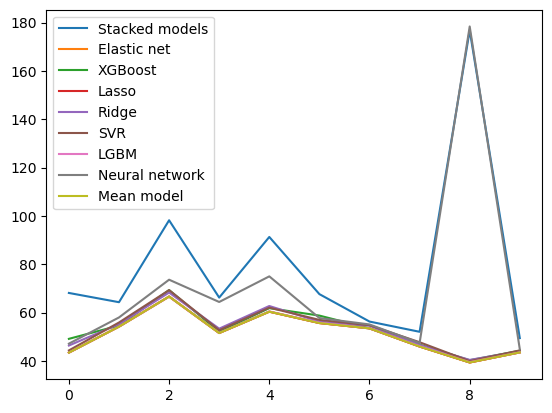

Average RMSE stacked models = 79.0236531070243
Average RMSE elastic net = 51.39779302700894
Average RMSE xgboost = 53.039591042607356
Average RMSE lasso = 51.39779302700894
Average RMSE ridge = 52.76328168202939
Average RMSE svr = 52.788236927010374
Average RMSE lgbm = 51.463085262303856
Average RMSE nn = 70.15166143394833
Average RMSE mean model = 51.39779302700894


In [18]:
# Plot rmse for each fold of each model
import matplotlib.pyplot as plt
plt.plot(rmse_stacked_list, label='Stacked models')
plt.plot(rmse_en_list, label='Elastic net')
plt.plot(rmse_xgb_list, label='XGBoost')
plt.plot(rmse_lasso_list, label='Lasso')
plt.plot(rmse_ridge_list, label='Ridge')
plt.plot(rmse_svr_list, label='SVR')
plt.plot(rmse_lgbm_list, label='LGBM')
plt.plot(rmse_nn_list, label='Neural network')
plt.plot(rmse_mean_list, label='Mean model')
plt.legend()
plt.show()

# Compute average RMSE
print(f'Average RMSE stacked models = {np.mean(rmse_stacked_list)}')
print(f'Average RMSE elastic net = {np.mean(rmse_en_list)}')
print(f'Average RMSE xgboost = {np.mean(rmse_xgb_list)}')
print(f'Average RMSE lasso = {np.mean(rmse_lasso_list)}')
print(f'Average RMSE ridge = {np.mean(rmse_ridge_list)}')
print(f'Average RMSE svr = {np.mean(rmse_svr_list)}')
print(f'Average RMSE lgbm = {np.mean(rmse_lgbm_list)}')
print(f'Average RMSE nn = {np.mean(rmse_nn_list)}')
print(f'Average RMSE mean model = {np.mean(rmse_mean_list)}')


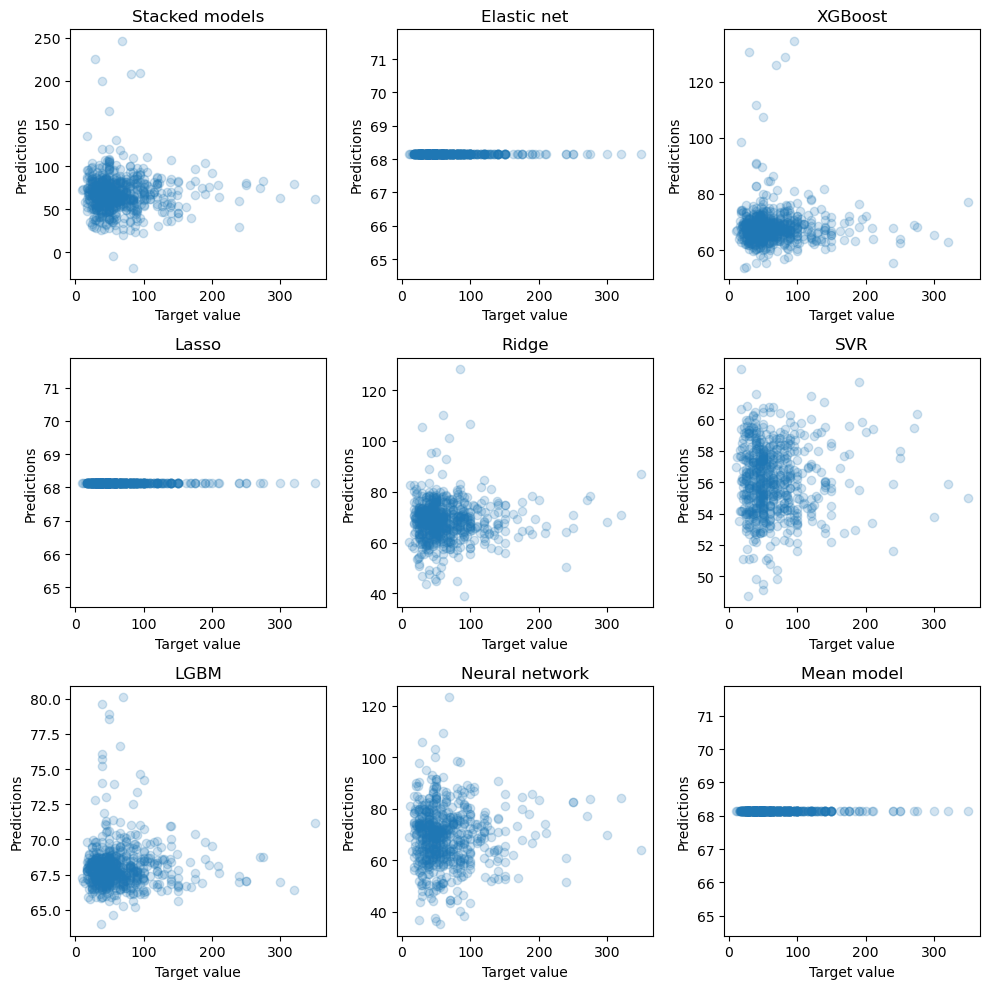

In [32]:
models = {
    'Stacked models': y_pred_stacked,
    'Elastic net': y_pred_en,
    'XGBoost': y_pred_xgb,
    'Lasso': y_pred_lasso,
    'Ridge': y_pred_ridge,
    'SVR': y_pred_svr,
    'LGBM': y_pred_lgbm,
    'Neural network': y_pred_nn,
    'Mean model': y_pred_mean
}

fig, axes = plt.subplots(3, 3, figsize=(10, 10))

for i, (model_name, predictions) in enumerate(models.items()):
    row = i // 3
    col = i % 3
    ax = axes[row, col]
    ax.scatter(y_test, predictions, alpha=0.2)
    ax.set_xlabel('Target value')
    ax.set_ylabel('Predictions')
    ax.set_title(model_name)

plt.tight_layout()
plt.show()